In [1]:

import time
import math
import json
import pickle
import warnings

import statistics

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt

from os import listdir
from os.path import join
from os.path import isfile

from tqdm import tqdm

from itertools import combinations

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import datasets
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score


from libsvm.svmutil import svm_problem
from libsvm.svmutil import svm_parameter
from libsvm.svmutil import svm_train
from libsvm.svmutil import svm_predict
from libsvm.svmutil import evaluations

from Function import svm_function

In [ ]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
def esvm_cutoff_predict(clf, x, cutoff):
    output = None
    for m in clf.model_array:
        p_label = m.predict(x)
        # proba = m.predict_proba(valid_x)[:, 1]
        # p_label = np.where(proba > cutoff, 1, 0)
        if output is None:
            output = np.array([p_label])
        else:
            output = np.append(output, np.array([p_label]), axis=0)
    
    
    pred_y = []
    pred_y_score = []
    for o in output.T:
        u, c = np.unique(o, return_counts=True)
        p_num = 0 if len(c[u == 1]) == 0 else c[u == 1][0]
        pred_y.append(1 if (p_num / sum(c)) > cutoff else 0)
    
    return pred_y

def esvm_decision_function_sum_predict(clf, x, cutoff=0):
    output = None
    for m in clf.model_array:
        proba = m.decision_function(x)
        if output is None:
            output = np.array([proba])
        else:
            output = np.append(output, np.array([proba]), axis=0)
    
    proba = np.sum(output, axis=0) / len(output)
    pred_y = np.where(proba > cutoff, 1, 0)
    
    return pred_y, proba

def esvm_cutoff_pref(clf, valid_x, valid_y, cutoff):
    
    pred_y = esvm_cutoff_predict(clf, valid_x, cutoff)
        
    test_roc_score = metrics.roc_auc_score(valid_y, pred_y)
    tn, fp, fn, tp = confusion_matrix(valid_y, pred_y).ravel()

    acc = (tn + tp) / (tn + fp + fn + tp)
    recall = tp / (fn + tp)
    prec = (tp / (fp + tp))
    spec = (tn / (tn + fp))
    npv = (tn / (tn + fn))
    f1sc = (2 * (tp / (fn + tp)) * (tp / (fp + tp)) / ((tp / (fn + tp)) + (tp / (fp + tp))))
    
    return acc, recall, prec, spec, npv, f1sc, test_roc_score

def predict_pref(pred_y, valid_y):
    test_roc_score = metrics.roc_auc_score(valid_y, pred_y)
    tn, fp, fn, tp = confusion_matrix(valid_y, pred_y).ravel()

    acc = (tn + tp) / (tn + fp + fn + tp)
    recall = tp / (fn + tp)
    prec = (tp / (fp + tp))
    spec = (tn / (tn + fp))
    npv = (tn / (tn + fn))
    f1sc = (2 * (tp / (fn + tp)) * (tp / (fp + tp)) / ((tp / (fn + tp)) + (tp / (fp + tp))))
    
    return acc, recall, prec, spec, npv, f1sc, test_roc_score

def rank_percentage(rank, value):
    if rank[-1] < value:
        o = (value - rank[-1]) / abs(max(rank) - min(rank)) + 1
    else:
        a = 0
        b = len(rank) - 1
        c = (b + a) // 2
        while(b > a and rank[c] != value):
            if rank[c] > value:
                b = c - 1
                c = (b + a) // 2
            elif rank[c] < value:
                a = c + 1
                c = (b + a) // 2
        if rank[c] > value:
            c = c - 0.5
        o = c / (len(rank) - 1)
    return o
        

def esvm_decision_value_rank_percentage_predict(clf, train_x, valid_x):
    pred_y, proba = esvm_decision_function_sum_predict(clf, train_x)
    
    true_proba = proba[proba >= 0]
    true_proba.sort()
    
    false_proba = proba[proba <= 0]
    false_proba = np.absolute(false_proba)
    false_proba.sort()
    
    pred_y, proba = esvm_decision_function_sum_predict(clf, valid_x)
    
    true_rank_percentage = [rank_percentage(true_proba, abs(p)) for p in proba]
    false_rank_percentage = [(rank_percentage(false_proba, abs(p)) * -1) for p in proba]
    
    percentage_proba = np.where(proba >= 0, true_rank_percentage, false_rank_percentage)

    return percentage_proba

def svm_decision_value_rank_percentage_predict(clf, train_x, valid_x):
    proba = clf.decision_function(train_x)
    
    true_proba = proba[proba >= 0]
    true_proba.sort()
    
    false_proba = proba[proba <= 0]
    false_proba = np.absolute(false_proba)
    false_proba.sort()
    
    proba = clf.decision_function(valid_x)
    
    true_rank_percentage = [rank_percentage(true_proba, abs(p)) for p in proba]
    false_rank_percentage = [(rank_percentage(false_proba, abs(p)) * -1) for p in proba]
    
    percentage_proba = np.where(proba > 0, true_rank_percentage, false_rank_percentage)
    return percentage_proba


In [4]:
m_train_x = np.load("data/merge_data/0916chiu/classifier/nuc_mRNA__cyto_mRNA_train.npy")
m_train_y = np.load("data/merge_data/0916chiu/classifier/nuc_mRNA__cyto_mRNA_train_y.npy")
m_test_x = np.load("data/merge_data/0916chiu/classifier/nuc_mRNA__cyto_mRNA_test.npy")
m_test_y = np.load("data/merge_data/0916chiu/classifier/nuc_mRNA__cyto_mRNA_test_y.npy")

with open("data/model/merge_data/0916chiu/classifier/nuc_mRNA__cyto_mRNA__svm.pickle", 'rb') as f:
    mrna_clf = pickle.load(f)

## merge seq, rbp 205

In [29]:
perf_list = []
for i in range(10):
    lnc_train_x = np.load("data/RBP_eclip/All/merge/fold/ensembl__merge__seq__RBPpred__RBPPWM_10-3_or__fold%s-train.npy" % i)
    lnc_train_y = np.load("data/RBP_eclip/All/merge/fold/ensembl__y__fold%s-train.npy" % i)
    lnc_test_x = np.load("data/RBP_eclip/All/merge/fold/ensembl__merge__seq__RBPpred__RBPPWM_10-3_or__fold%s-test.npy" % i)
    lnc_test_y = np.load("data/RBP_eclip/All/merge/fold/ensembl__y__fold%s-test.npy" % i)
    
    with open("data/model/merge_data/0713/ensembl__merge__seq__RBPpred__RBPPWM_10-3_or__fold%s.pickle" % i, 'rb') as f:
        lncrna_clf = pickle.load(f)
    
    lnc_proba = esvm_decision_value_rank_percentage_predict(clf=lncrna_clf, train_x=lnc_train_x, valid_x=lnc_test_x)
    m_proba = svm_decision_value_rank_percentage_predict(clf=mrna_clf, train_x=lnc_train_x[:, :196], valid_x=lnc_test_x[:, :196])

    lnc_pred_y = np.where(lnc_proba > 0, 1, 0)
    m_pred_y = np.where(m_proba > 0, 1, 0)
    pred_y = np.where((abs(lnc_proba) > abs(m_proba)), lnc_pred_y, m_pred_y)
    
    acc, recall, prec, spec, npv, f1sc, test_roc_score = predict_pref(pred_y, lnc_test_y)
    perf_list.append([acc, recall, prec, spec, npv, f1sc, test_roc_score])

/home/jand/.conda/envs/jand_venv/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator NuSVC from version 1.2.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/jand/.conda/envs/jand_venv/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator NuSVC from version 1.2.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/jand/.conda/envs/jand_venv/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator NuSVC from version 1.2.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/jand/.conda/envs/jand_venv/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator NuSVC from version 1.2.2 when using version 0.24.2. This might lead to breakin

In [32]:
df = pd.DataFrame(perf_list, columns=["Accy", "Recall", "Prec", "Spec", "Npv", "F1sc", "AUROC"])

In [34]:
json_dict = {
    "fold Accy": df["Accy"].to_list(),
    "avg Accy": sum(df["Accy"]) / len(df["Accy"]),
    "std Accy": np.std(df["Accy"]),
    "fold Recall": df["Recall"].to_list(),
    "avg Recall": sum(df["Recall"]) / len(df["Recall"]),
    "std Recall": np.std(df["Recall"]),
    "fold Prec": df["Prec"].to_list(),
    "avg Prec": sum(df["Prec"]) / len(df["Prec"]),
    "std Prec": np.std(df["Prec"]),
    "fold Spec": df["Spec"].to_list(),
    "avg Spec": sum(df["Spec"]) / len(df["Spec"]),
    "std Spec": np.std(df["Spec"]),
    "fold Npv": df["Npv"].to_list(),
    "avg Npv": sum(df["Npv"]) / len(df["Npv"]),
    "std Npv": np.std(df["Npv"]),
    "fold F1sc": df["F1sc"].to_list(),
    "avg F1sc": sum(df["F1sc"]) / len(df["F1sc"]),
    "std F1sc": np.std(df["F1sc"]),
    "fold AUROC": df["AUROC"].to_list(),
    "avg AUROC": sum(df["AUROC"]) / len(df["AUROC"]),
    "std AUROC": np.std(df["AUROC"]),
}
 

In [37]:
with open('data/model/merge_data/0713/perf/ensembl__merge__seq__RBP205___mRNA.json', 'w') as fp:
    json.dump(json_dict, fp)

In [24]:
temp = np.append([lnc_proba], [m_proba], axis=0)
print(np.unique(lnc_test_y, return_counts=True))
print(temp[:, lnc_test_y == 1].shape)
print(temp[:, lnc_test_y == 0].shape)

(array([0, 1]), array([ 36, 246]))
(2, 246)
(2, 36)


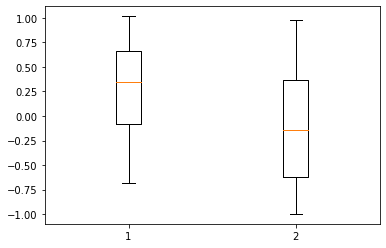

In [25]:
plt.boxplot(temp[:, lnc_test_y == 1].T)
plt.show()

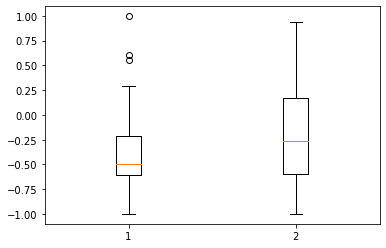

In [26]:
plt.boxplot(temp[:, lnc_test_y == 0].T)
plt.show()

## Pse in one2 and RBP

In [9]:
# lnc_train_x = np.load("data/merge_data/0916chiu/classifier/nuc_lncRNA__cyto_lncRNA_train.npy")
# lnc_train_y = np.load("data/merge_data/0916chiu/classifier/nuc_lncRNA__cyto_lncRNA_train_y.npy")
# lnc_test_x = np.load("data/merge_data/0916chiu/classifier/nuc_lncRNA__cyto_lncRNA_test.npy")
# lnc_test_y = np.load("data/merge_data/0916chiu/classifier/nuc_lncRNA__cyto_lncRNA_test_y.npy")

# lnc_train_x = np.load("data/merge_data/seq_rbp/pse_in_one2__rbp_10-3_-log10__train__x.npy")
# lnc_train_y = np.load("data/merge_data/seq_rbp/pse_in_one2__rbp_10-3_-log10__train__y.npy")
# lnc_test_x = np.load("data/merge_data/seq_rbp/pse_in_one2__rbp_10-3_-log10__test__x.npy")
# lnc_test_y = np.load("data/merge_data/seq_rbp/pse_in_one2__rbp_10-3_-log10__test__y.npy")

m_train_x = np.load("data/merge_data/0916chiu/classifier/nuc_mRNA__cyto_mRNA_train.npy")
m_train_y = np.load("data/merge_data/0916chiu/classifier/nuc_mRNA__cyto_mRNA_train_y.npy")
m_test_x = np.load("data/merge_data/0916chiu/classifier/nuc_mRNA__cyto_mRNA_test.npy")
m_test_y = np.load("data/merge_data/0916chiu/classifier/nuc_mRNA__cyto_mRNA_test_y.npy")

In [4]:
with open("data/model/merge_data/pse_in_one2__rbp_10-3_-log10__esvm_e512_p10_f10_s10_t1000_hasNu.pickle", 'rb') as f:
    lncrna_clf = pickle.load(f)

In [5]:
with open("data/model/merge_data/0916chiu/classifier/nuc_mRNA__cyto_mRNA__svm.pickle", 'rb') as f:
    mrna_clf = pickle.load(f)

In [20]:
lnc_cutoff = 0.00
m_cutoff = 0.00

print("lncRNA cutoff %s, mRNA cutoff %s, lncRNA dataset" % (lnc_cutoff, m_cutoff))
lnc_proba = esvm_decision_value_rank_percentage_predict(clf=lncrna_clf, train_x=lnc_train_x, valid_x=lnc_test_x)
m_proba = svm_decision_value_rank_percentage_predict(clf=mrna_clf, train_x=lnc_train_x[:, :196], valid_x=lnc_test_x[:, :196])

lnc_pred_pro = lnc_proba - lnc_cutoff
lnc_pred_y = np.where(lnc_pred_pro > 0, 1, 0)

m_pred_pro = m_proba - m_cutoff
m_pred_y = np.where(m_pred_pro > 0, 1, 0)

pred_y = np.where((abs(lnc_pred_pro) > abs(m_pred_pro)) | np.array(lnc_pred_y, dtype=bool), lnc_pred_y, m_pred_y)
acc, recall, prec, spec, npv, f1sc, test_roc_score = predict_pref(pred_y, lnc_test_y)
print("lncRNA N, high")
print(acc, recall, prec, spec, npv, f1sc, test_roc_score)

lncRNA cutoff 0.0, mRNA cutoff 0.0, lncRNA dataset
lncRNA N, high
0.8130511463844797 0.8901960784313725 0.9007936507936508 0.12280701754385964 0.1111111111111111 0.8954635108481263 0.5065015479876162


---

In [2]:
with open("data/model/merge_data/0916chiu/classifier/nuc_lncRNA__cyto_lncRNA__esvms10_v4.pickle", 'rb') as f:
    lncrna_clf = pickle.load(f)

In [6]:
len(lncrna_clf.model_array)

70

In [14]:
# mRNA model of mRNA data test
print("mRNA model, mRNA dataset")
pred_y = mrna_clf.predict(m_test_x)

acc, recall, prec, spec, npv, f1sc, test_roc_score = predict_pref(pred_y, m_test_y)
print(acc, recall, prec, spec, npv, f1sc, test_roc_score)
# mRNA model of lncRNA data test
print("mRNA model, lncRNA dataset")
pred_y = mrna_clf.predict(lnc_test_x[:,:196])

acc, recall, prec, spec, npv, f1sc, test_roc_score = predict_pref(pred_y, lnc_test_y)
print(acc, recall, prec, spec, npv, f1sc, test_roc_score)

mRNA model, mRNA dataset
0.6595339990489777 0.6375727348295926 0.7325692454632283 0.6888888888888889 0.5871212121212122 0.6817777777777778 0.6632308118592408
mRNA model, lncRNA dataset
0.42504409171075835 0.40588235294117647 0.9 0.5964912280701754 0.10089020771513353 0.5594594594594594 0.5011867905056759


In [15]:
# lncRNA model of mRNA data test
# print("lncRNA model, mRNA dataset")
# pred_y, _ = lncrna_clf.predict(m_test_x)

# acc, recall, prec, spec, npv, f1sc, test_roc_score = predict_pref(pred_y, m_test_y)
# print(acc, recall, prec, spec, npv, f1sc, test_roc_score)
# lncRNA model of lncRNA data test
print("lncRNA model, lncRNA dataset")
pred_y, _ = lncrna_clf.predict(lnc_test_x)

acc, recall, prec, spec, npv, f1sc, test_roc_score = predict_pref(pred_y, lnc_test_y)
print(acc, recall, prec, spec, npv, f1sc, test_roc_score)

lncRNA model, lncRNA dataset
0.47266313932980597 0.4392156862745098 0.9451476793248945 0.7719298245614035 0.13333333333333333 0.5997322623828648 0.6055727554179566


In [6]:
lnc_cutoff = 0.00
m_cutoff = 0.00
print("lncRNA cutoff %s, mRNA cutoff %s, mRNA dataset" % (lnc_cutoff, m_cutoff))

lnc_proba = esvm_decision_value_rank_percentage_predict(clf=lncrna_clf, train_x=m_train_x, valid_x=m_test_x)
m_proba = svm_decision_value_rank_percentage_predict(clf=mrna_clf, train_x=m_train_x, valid_x=m_test_x)

lnc_pred_pro = lnc_proba - lnc_cutoff
lnc_pred_y = np.where(lnc_pred_pro > 0, 1, 0)

m_pred_pro = m_proba - m_cutoff
m_pred_y = np.where(m_pred_pro > 0, 1, 0)

pred_y = np.where((abs(lnc_pred_pro) > abs(m_pred_pro)) | np.array(lnc_pred_y, dtype=bool), lnc_pred_y, m_pred_y)
acc, recall, prec, spec, npv, f1sc, test_roc_score = predict_pref(pred_y, m_test_y)
print("lncRNA N, high")
print(acc, recall, prec, spec, npv, f1sc, test_roc_score)


print("lncRNA cutoff %s, mRNA cutoff %s, lncRNA dataset" % (lnc_cutoff, m_cutoff))
lnc_proba = esvm_decision_value_rank_percentage_predict(clf=lncrna_clf, train_x=lnc_train_x, valid_x=lnc_test_x)
m_proba = svm_decision_value_rank_percentage_predict(clf=mrna_clf, train_x=lnc_train_x, valid_x=lnc_test_x)

lnc_pred_pro = lnc_proba - lnc_cutoff
lnc_pred_y = np.where(lnc_pred_pro > 0, 1, 0)

m_pred_pro = m_proba - m_cutoff
m_pred_y = np.where(m_pred_pro > 0, 1, 0)

pred_y = np.where((abs(lnc_pred_pro) > abs(m_pred_pro)) | np.array(lnc_pred_y, dtype=bool), lnc_pred_y, m_pred_y)
acc, recall, prec, spec, npv, f1sc, test_roc_score = predict_pref(pred_y, lnc_test_y)
print("lncRNA N, high")
print(acc, recall, prec, spec, npv, f1sc, test_roc_score)

lncRNA cutoff 0.0, mRNA cutoff 0.0, mRNA dataset
lncRNA N, high
0.6238706609605326 0.769742310889443 0.6430555555555556 0.4288888888888889 0.5822021116138764 0.7007188800605372 0.5993155998891659
lncRNA cutoff 0.0, mRNA cutoff 0.0, lncRNA dataset
lncRNA N, high
0.7125220458553791 0.7287128712871287 0.934010152284264 0.5806451612903226 0.20809248554913296 0.8186874304783093 0.6546790162887256


In [8]:
lnc_cutoff = -0.01
m_cutoff = -0.01
print("lncRNA cutoff %s, mRNA cutoff %s, mRNA dataset" % (lnc_cutoff, m_cutoff))

lnc_proba = esvm_decision_value_rank_percentage_predict(clf=lncrna_clf, train_x=m_train_x, valid_x=m_test_x)
m_proba = svm_decision_value_rank_percentage_predict(clf=mrna_clf, train_x=m_train_x, valid_x=m_test_x)

lnc_pred_pro = lnc_proba - lnc_cutoff
lnc_pred_y = np.where(lnc_pred_pro > 0, 1, 0)

m_pred_pro = m_proba - m_cutoff
m_pred_y = np.where(m_pred_pro > 0, 1, 0)

pred_y = np.where(abs(lnc_pred_pro) > abs(m_pred_pro), lnc_pred_y, m_pred_y)
acc, recall, prec, spec, npv, f1sc, test_roc_score = predict_pref(pred_y, m_test_y)
print("high")
print(acc, recall, prec, spec, npv, f1sc, test_roc_score)


print("lncRNA cutoff %s, mRNA cutoff %s, lncRNA dataset" % (lnc_cutoff, m_cutoff))
lnc_proba = esvm_decision_value_rank_percentage_predict(clf=lncrna_clf, train_x=lnc_train_x, valid_x=lnc_test_x)
m_proba = svm_decision_value_rank_percentage_predict(clf=mrna_clf, train_x=lnc_train_x, valid_x=lnc_test_x)

lnc_pred_pro = lnc_proba - lnc_cutoff
lnc_pred_y = np.where(lnc_pred_pro > 0, 1, 0)

m_pred_pro = m_proba - m_cutoff
m_pred_y = np.where(m_pred_pro > 0, 1, 0)

pred_y = np.where(abs(lnc_pred_pro) > abs(m_pred_pro), lnc_pred_y, m_pred_y)
acc, recall, prec, spec, npv, f1sc, test_roc_score = predict_pref(pred_y, lnc_test_y)
print("high")
print(acc, recall, prec, spec, npv, f1sc, test_roc_score)


lncRNA cutoff -0.01, mRNA cutoff -0.01, mRNA dataset
high
0.6509747979077508 0.6940980881130507 0.6952539550374688 0.5933333333333334 0.5920177383592018 0.6946755407653911 0.643715710723192
lncRNA cutoff -0.01, mRNA cutoff -0.01, lncRNA dataset
high
0.5767195767195767 0.5683168316831683 0.9288025889967637 0.6451612903225806 0.15503875968992248 0.7051597051597052 0.6067390610028744


In [19]:
fold_mrna_train_x = []
fold_mrna_train_y = []
fold_mrna_valid_x = []
fold_mrna_valid_y = []
for i in range(10):
    train_x = np.load("data/merge_data/0916chiu/classifier/10fold/nuc_mRNA__cyto_mRNA_train_x_fold%s.npy" % i)
    train_y = np.load("data/merge_data/0916chiu/classifier/10fold/nuc_mRNA__cyto_mRNA_train_y_fold%s.npy" % i)
    valid_x = np.load("data/merge_data/0916chiu/classifier/10fold/nuc_mRNA__cyto_mRNA_valid_x_fold%s.npy" % i)
    valid_y = np.load("data/merge_data/0916chiu/classifier/10fold/nuc_mRNA__cyto_mRNA_valid_y_fold%s.npy" % i)
    
    fold_mrna_train_x.append(train_x)
    fold_mrna_train_y.append(train_y)
    fold_mrna_valid_x.append(valid_x)
    fold_mrna_valid_y.append(valid_y)

In [2]:
fold_train_x = []
fold_train_y = []
fold_valid_x = []
fold_valid_y = []
for i in range(10):
    train_x = np.load("data/merge_data/0916chiu/classifier/10fold/nuc_lncRNA__cyto_lncRNA_train_x_fold%s.npy" % i)
    train_y = np.load("data/merge_data/0916chiu/classifier/10fold/nuc_lncRNA__cyto_lncRNA_train_y_fold%s.npy" % i)
    valid_x = np.load("data/merge_data/0916chiu/classifier/10fold/nuc_lncRNA__cyto_lncRNA_valid_x_fold%s.npy" % i)
    valid_y = np.load("data/merge_data/0916chiu/classifier/10fold/nuc_lncRNA__cyto_lncRNA_valid_y_fold%s.npy" % i)
    
    fold_train_x.append(train_x)
    fold_train_y.append(train_y)
    fold_valid_x.append(valid_x)
    fold_valid_y.append(valid_y)

In [4]:
print(np.unique(train_y, return_counts=True))

(array([0., 1.]), array([ 278, 1759]))


In [4]:
def esvm_decision_value_percentage_predict(clf, train_x, valid_x):
    pred_y, proba = esvm_decision_function_sum_predict(clf, train_x)
    true_max = max(proba)
    false_max = min(proba)
    
    pred_y, proba = esvm_decision_function_sum_predict(clf, valid_x)
    
    percentage_proba = np.where(proba > 0, proba / true_max, - proba / false_max)

    return pred_y, percentage_proba

fold_lnc_pred_y = []
fold_lnc_pred_pro = []
fold_m_pred_y = []
fold_m_pred_pro = []
for i in range(10):
    train_x = fold_train_x[i]
    valid_x = fold_valid_x[i]
    
    with open("data/model/merge_data/0916chiu/classifier/10fold/nuc_lncRNA__cyto_lncRNA__fold%s__esvms10_v4.pickle" % i, 'rb') as f:
        lncrna_clf = pickle.load(f)
        
    pred_y, percentage_proba = esvm_decision_value_percentage_predict(lncrna_clf, train_x=train_x, valid_x=valid_x)
    fold_lnc_pred_y.append(pred_y)
    fold_lnc_pred_pro.append(percentage_proba)
    
    with open("data/model/merge_data/0916chiu/classifier/nuc_mRNA__cyto_mRNA__svm.pickle", 'rb') as f:
        mrna_clf = pickle.load(f)
    
    proba = mrna_clf.decision_function(train_x)
    true_max = max(proba)
    false_max = min(proba)
    
    proba = mrna_clf.decision_function(valid_x)
    percentage_proba = np.where(proba > 0, proba / true_max, - proba / false_max)
    fold_m_pred_y.append(np.where(percentage_proba > 0, 1, 0))
    fold_m_pred_pro.append(percentage_proba)
    

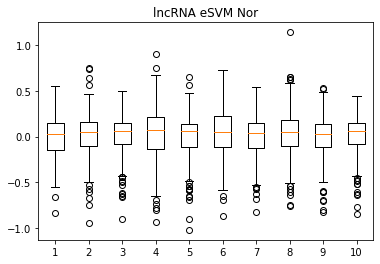

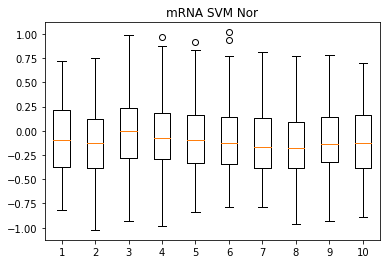

In [83]:
lnc_fold_pred_y = []
lnc_fold_pred_pro = []
m_fold_pred_y = []
m_fold_pred_pro = []
for i in range(10):
    lnc_pred_pro = fold_lnc_pred_pro[i]
    lnc_pred_y = np.where(lnc_pred_pro > 0, 1, 0)

    lnc_fold_pred_y.append(lnc_pred_y)
    lnc_fold_pred_pro.append(lnc_pred_pro)

    m_pred_pro = fold_m_pred_pro[i]
    m_pred_y = np.where(m_pred_pro > 0, 1, 0)
    m_fold_pred_y.append(m_pred_y)
    m_fold_pred_pro.append(m_pred_pro)
plt.boxplot(lnc_fold_pred_pro)
plt.title("lncRNA eSVM Nor")
plt.show()
plt.boxplot(m_fold_pred_pro)
plt.title("mRNA SVM Nor")
plt.show()

In [5]:


fold_lnc_pred_y = []
fold_lnc_pred_pro = []
fold_m_pred_y = []
fold_m_pred_pro = []
for i in range(10):
    train_x = fold_train_x[i]
    valid_x = fold_valid_x[i]
    
    with open("data/model/merge_data/0916chiu/classifier/10fold/nuc_lncRNA__cyto_lncRNA__fold%s__esvms10_v4.pickle" % i, 'rb') as f:
        lncrna_clf = pickle.load(f)
        
    pred_y, percentage_proba = esvm_decision_value_rank_percentage_predict(lncrna_clf, train_x=train_x, valid_x=valid_x)
    fold_lnc_pred_y.append(pred_y)
    fold_lnc_pred_pro.append(percentage_proba)
    
    with open("data/model/merge_data/0916chiu/classifier/nuc_mRNA__cyto_mRNA__svm.pickle", 'rb') as f:
        mrna_clf = pickle.load(f)
    
    proba = mrna_clf.decision_function(train_x)
    
    true_proba = proba[proba >= 0]
    true_proba.sort()
    
    false_proba = proba[proba <= 0]
    false_proba = np.absolute(false_proba)
    false_proba.sort()
    
    proba = mrna_clf.decision_function(valid_x)
    
    true_rank_percentage = [rank_percentage(true_proba, abs(p)) for p in proba]
    false_rank_percentage = [(rank_percentage(false_proba, abs(p)) * -1) for p in proba]
    
    percentage_proba = np.where(proba > 0, true_rank_percentage, false_rank_percentage)
    
    fold_m_pred_y.append(np.where(percentage_proba > 0, 1, 0))
    fold_m_pred_pro.append(percentage_proba)

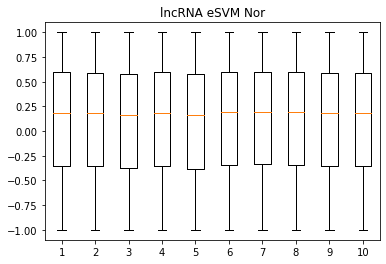

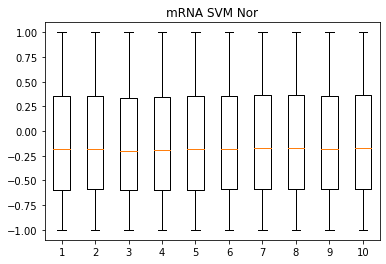

In [87]:
lnc_fold_pred_y = []
lnc_fold_pred_pro = []
m_fold_pred_y = []
m_fold_pred_pro = []
for i in range(10):
    lnc_pred_pro = fold_lnc_pred_pro[i]
    lnc_pred_y = np.where(lnc_pred_pro > 0, 1, 0)

    lnc_fold_pred_y.append(lnc_pred_y)
    lnc_fold_pred_pro.append(lnc_pred_pro)

    m_pred_pro = fold_m_pred_pro[i]
    m_pred_y = np.where(m_pred_pro > 0, 1, 0)
    m_fold_pred_y.append(m_pred_y)
    m_fold_pred_pro.append(m_pred_pro)
plt.boxplot(lnc_fold_pred_pro)
plt.title("lncRNA eSVM Nor")
plt.show()
plt.boxplot(m_fold_pred_pro)
plt.title("mRNA SVM Nor")
plt.show()

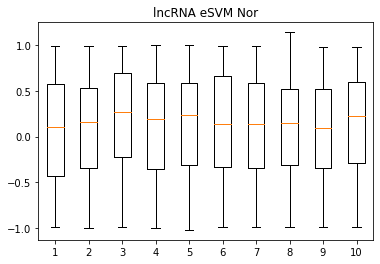

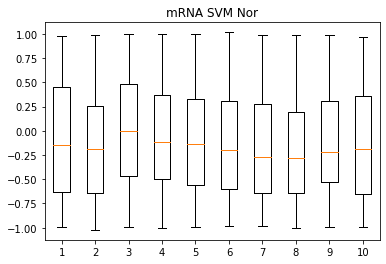

In [90]:
lnc_fold_pred_y = []
lnc_fold_pred_pro = []
m_fold_pred_y = []
m_fold_pred_pro = []
for i in range(10):
    lnc_pred_pro = fold_lnc_pred_pro[i]
    lnc_pred_y = np.where(lnc_pred_pro > 0, 1, 0)

    lnc_fold_pred_y.append(lnc_pred_y)
    lnc_fold_pred_pro.append(lnc_pred_pro)

    m_pred_pro = fold_m_pred_pro[i]
    m_pred_y = np.where(m_pred_pro > 0, 1, 0)
    m_fold_pred_y.append(m_pred_y)
    m_fold_pred_pro.append(m_pred_pro)
plt.boxplot(lnc_fold_pred_pro)
plt.title("lncRNA eSVM Nor")
plt.show()
plt.boxplot(m_fold_pred_pro)
plt.title("mRNA SVM Nor")
plt.show()

In [6]:
lnc_cutoff_fold_pred_y = []
lnc_cutoff_fold_pred_pro = []
m_cutoff_fold_pred_y = []
m_cutoff_fold_pred_pro = []
cutoff_array = []
for cutoff in range(-100, 100, 1):
    cutoff = cutoff / 100
    cutoff_array.append(cutoff)
    
    lnc_fold_pred_y = []
    lnc_fold_pred_pro = []
    m_fold_pred_y = []
    m_fold_pred_pro = []
    for i in range(10):
        lnc_pred_pro = fold_lnc_pred_pro[i] - cutoff
        lnc_pred_y = np.where(lnc_pred_pro > 0, 1, 0)
        
        lnc_fold_pred_y.append(lnc_pred_y)
        lnc_fold_pred_pro.append(lnc_pred_pro)
        
        m_pred_pro = fold_m_pred_pro[i] - cutoff
        m_pred_y = np.where(m_pred_pro > 0, 1, 0)
        m_fold_pred_y.append(m_pred_y)
        m_fold_pred_pro.append(m_pred_pro)
        
    lnc_cutoff_fold_pred_y.append(lnc_fold_pred_y)
    lnc_cutoff_fold_pred_pro.append(lnc_fold_pred_pro)
    m_cutoff_fold_pred_y.append(m_fold_pred_y)
    m_cutoff_fold_pred_pro.append(m_fold_pred_pro)

In [103]:
print(len(lnc_cutoff_fold_pred_y))
print(len(m_cutoff_fold_pred_y))

200
200


In [12]:
acc_array = []
df["Recall"] = []
prec_array = []
spec_array = []
npv_array = []
f1sc_array = []
auroc_array = []

lnc_cutoff_idx = 105
m_cutoff_idx = 127

print("lncRNA cutoff %s, mRNA cutoff %s" % (cutoff_array[lnc_cutoff_idx], cutoff_array[m_cutoff_idx]))

for fold_idx in range(10):
    valid_x = fold_valid_x[fold_idx]
    valid_y = fold_valid_y[fold_idx]
    
    lnc_pred_y = lnc_cutoff_fold_pred_y[lnc_cutoff_idx][fold_idx]
    m_pred_y = m_cutoff_fold_pred_y[m_cutoff_idx][fold_idx]
    
    lnc_pred_pro = lnc_cutoff_fold_pred_pro[lnc_cutoff_idx][fold_idx]
    m_pred_pro = m_cutoff_fold_pred_pro[m_cutoff_idx][fold_idx]
    
    # pred_y = np.logical_and(lnc_pred_y, m_pred_y)
    # pred_y = np.logical_or(lnc_pred_y, m_pred_y)
    # pred_y = np.where(abs(lnc_pred_pro) > abs(m_pred_pro), lnc_pred_y, m_pred_y)
    pred_y = np.where((abs(lnc_pred_pro) > abs(m_pred_pro)) | np.array(lnc_pred_y, dtype=bool), lnc_pred_y, m_pred_y)

    
    acc, recall, prec, spec, npv, f1sc, test_roc_score = predict_pref(pred_y, valid_y)
    
    acc_array.append(acc)
    recall_array.append(recall)
    prec_array.append(prec)
    spec_array.append(spec)
    npv_array.append(npv)
    f1sc_array.append(f1sc)
    auroc_array.append(test_roc_score)
    
print(["esvms10_v4__lnc_cutoff%s__m_cutoff%s" % (cutoff_array[lnc_cutoff_idx], cutoff_array[m_cutoff_idx]),
    sum(acc_array) / len(acc_array),
    np.std(acc_array),
    sum(recall_array) / len(recall_array),
    np.std(recall_array),
    sum(prec_array) / len(prec_array),
    np.std(prec_array),
    sum(spec_array) / len(spec_array),
    np.std(spec_array),
    sum(npv_array) / len(npv_array),
    np.std(npv_array),
    sum(f1sc_array) / len(f1sc_array),
    np.std(f1sc_array),
    sum(auroc_array) / len(auroc_array),
    np.std(auroc_array)])

lncRNA cutoff 0.05, mRNA cutoff 0.27
['esvms10_v4__lnc_cutoff0.05__m_cutoff0.27', 0.652360531753148, 0.027724099258082478, 0.6472833081411922, 0.030789776009572518, 0.9302296132482916, 0.01602053546518583, 0.6842714424951268, 0.0443163509070127, 0.23034461549927224, 0.04154981620956939, 0.7629563766058268, 0.022738951504880298, 0.6657773753181594, 0.026891845493542576]


In [102]:
perf_array = []
for i in range(len(lnc_cutoff_fold_pred_y)):
    for j in range(len(m_cutoff_fold_pred_y)):
        
        acc_array = []
        recall_array = []
        prec_array = []
        spec_array = []
        npv_array = []
        f1sc_array = []
        auroc_array = []
        
        for fold_idx in range(10):
            valid_x = fold_valid_x[fold_idx]
            valid_y = fold_valid_y[fold_idx]
            
            lnc_pred_y = lnc_cutoff_fold_pred_y[i][fold_idx]
            m_pred_y = m_cutoff_fold_pred_y[j][fold_idx]
            
            lnc_pred_pro = lnc_cutoff_fold_pred_pro[i][fold_idx]
            m_pred_pro = m_cutoff_fold_pred_pro[j][fold_idx]
            
            # pred_y = np.logical_and(lnc_pred_y, m_pred_y)
            # pred_y = np.logical_or(lnc_pred_y, m_pred_y)
            # pred_y = np.where(abs(lnc_pred_pro) > abs(m_pred_pro), lnc_pred_y, m_pred_y)
            pred_y = np.where((abs(lnc_pred_pro) > abs(m_pred_pro)) | np.array(lnc_pred_y, dtype=bool), lnc_pred_y, m_pred_y)

            
            acc, recall, prec, spec, npv, f1sc, test_roc_score = predict_pref(pred_y, valid_y)
            
            acc_array.append(acc)
            recall_array.append(recall)
            prec_array.append(prec)
            spec_array.append(spec)
            npv_array.append(npv)
            f1sc_array.append(f1sc)
            auroc_array.append(test_roc_score)
            
        perf_array.append(["esvms10_v4__lnc_cutoff%s__m_cutoff%s" % (cutoff_array[i], cutoff_array[j]),
            sum(acc_array) / len(acc_array),
            np.std(acc_array),
            sum(recall_array) / len(recall_array),
            np.std(recall_array),
            sum(prec_array) / len(prec_array),
            np.std(prec_array),
            sum(spec_array) / len(spec_array),
            np.std(spec_array),
            sum(npv_array) / len(npv_array),
            np.std(npv_array),
            sum(f1sc_array) / len(f1sc_array),
            np.std(f1sc_array),
            sum(auroc_array) / len(auroc_array),
            np.std(auroc_array)])

/home/jand/.conda/envs/test_venv/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in long_scalars
/home/jand/.conda/envs/test_venv/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in long_scalars
/home/jand/.conda/envs/test_venv/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in long_scalars
/home/jand/.conda/envs/test_venv/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in long_scalars
/home/jand/.conda/envs/test_venv/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in long_scalars
/home/jand/.conda/envs/test_venv/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in long_scalars
/home/jand/.conda/envs/test_venv/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered i

In [104]:
perf_df = pd.DataFrame(perf_array, columns=["name", 
                                            "Avg Accy", "Std Accy",
                                            "Avg Recall", "Std Recall",
                                            "Avg Prec", "Std Prec",
                                            "Avg Spec", "Std Spec",
                                            "Avg NPV", "Std NPV",
                                            "Avg F1sc", "Std F1sc",
                                            "Avg AUROC", "Std AUROC"])
perf_df
perf_df.to_csv("data/model/merge_data/0916chiu/classifier/10fold/perf/lncRNA_esvms10_v4__mRNA_svm_v2__cutoff_v4_percentage_v2__lnc_N_high.csv", index=False)

In [17]:
acc_array = []
recall_array = []
prec_array = []
spec_array = []
npv_array = []
f1sc_array = []
auroc_array = []

for fold_idx in range(10):
    valid_x = fold_valid_x[fold_idx]
    valid_y = fold_valid_y[fold_idx]
    
    lnc_pred_y = fold_lnc_pred_y[fold_idx]
    m_pred_y = fold_m_pred_y[fold_idx]
    
    lnc_pred_pro = fold_lnc_pred_pro[fold_idx]
    m_pred_pro = fold_m_pred_pro[fold_idx]
    
    # pred_y = np.logical_and(lnc_pred_y, m_pred_y)
    # pred_y = np.logical_or(lnc_pred_y, m_pred_y)
    # pred_y = np.where(abs(lnc_pred_pro) > abs(m_pred_pro), lnc_pred_y, m_pred_y)
    pred_y = np.where((abs(lnc_pred_pro) > abs(m_pred_pro)) | np.array(lnc_pred_y, dtype=bool), lnc_pred_y, m_pred_y)

    
    acc, recall, prec, spec, npv, f1sc, test_roc_score = predict_pref(pred_y, valid_y)
    
    acc_array.append(acc)
    recall_array.append(recall)
    prec_array.append(prec)
    spec_array.append(spec)
    npv_array.append(npv)
    f1sc_array.append(f1sc)
    auroc_array.append(test_roc_score)
    
print([
    sum(acc_array) / len(acc_array),
    np.std(acc_array),
    sum(recall_array) / len(recall_array),
    np.std(recall_array),
    sum(prec_array) / len(prec_array),
    np.std(prec_array),
    sum(spec_array) / len(spec_array),
    np.std(spec_array),
    sum(npv_array) / len(npv_array),
    np.std(npv_array),
    sum(f1sc_array) / len(f1sc_array),
    np.std(f1sc_array),
    sum(auroc_array) / len(auroc_array),
    np.std(auroc_array)])

[0.6890179720088886, 0.035684679771328054, 0.7068359270038034, 0.03436193039887471, 0.9145833075415017, 0.018729948485473602, 0.5663757088428141, 0.08822939299699366, 0.23131276891036762, 0.05912018696695775, 0.7970522658281134, 0.026037852114856142, 0.6366058179233087, 0.05307682202189479]


In [ ]:
lnc_cutoff_fold_pred_y = []
lnc_cutoff_fold_pred_pro = []
cutoff_lnc_array = []
for cutoff_lnc in range(-300, 304, 1):
    cutoff_lnc = cutoff_lnc / 100
    cutoff_lnc_array.append(cutoff_lnc)
    
    fold_pred_y = []
    fold_pred_pro = []
    for i in range(10):
        lnc_pred_pro = fold_lnc_pred_pro[i] - cutoff_lnc
        lnc_pred_y = np.where(lnc_pred_pro > 0, 1, 0)
        
        fold_pred_y.append(lnc_pred_y)
        fold_pred_pro.append(lnc_pred_pro)
        
    lnc_cutoff_fold_pred_y.append(fold_pred_y)
    lnc_cutoff_fold_pred_pro.append(fold_pred_pro)

In [ ]:
fold_lnc_pred_pro = []
for i in range(10):
    valid_x = fold_valid_x[i]
    
    with open("data/model/merge_data/0916chiu/classifier/10fold/nuc_lncRNA__cyto_lncRNA__fold%s__esvms10_v4.pickle" % i, 'rb') as f:
        lncrna_clf = pickle.load(f)
    
    lnc_pred_y, lnc_pred_pro = esvm_decision_function_sum_predict(lncrna_clf, valid_x, cutoff=0)
    fold_lnc_pred_pro.append(lnc_pred_pro)

lnc_cutoff_fold_pred_y = []
lnc_cutoff_fold_pred_pro = []
cutoff_lnc_array = []
for cutoff_lnc in range(-300, 304, 1):
    cutoff_lnc = cutoff_lnc / 100
    cutoff_lnc_array.append(cutoff_lnc)
    
    fold_pred_y = []
    fold_pred_pro = []
    for i in range(10):
        lnc_pred_pro = fold_lnc_pred_pro[i] - cutoff_lnc
        lnc_pred_y = np.where(lnc_pred_pro > 0, 1, 0)
        
        fold_pred_y.append(lnc_pred_y)
        fold_pred_pro.append(lnc_pred_pro)
        
    lnc_cutoff_fold_pred_y.append(fold_pred_y)
    lnc_cutoff_fold_pred_pro.append(fold_pred_pro)

In [ ]:
fold_m_pred_pro = []
for i in range(10):
    valid_x = fold_valid_x[i]
    
    with open("data/model/merge_data/0916chiu/classifier/nuc_mRNA__cyto_mRNA__svm.pickle", 'rb') as f:
        mrna_clf = pickle.load(f)
    
    proba = mrna_clf.decision_function(valid_x)
    fold_m_pred_pro.append(proba)

m_cutoff_fold_pred_y = []
m_cutoff_fold_pred_pro = []
cutoff_m_array = []
for cutoff_m in range(-200, 204, 1):
    cutoff_m = cutoff_m / 100
    cutoff_m_array.append(cutoff_m)
    
    fold_pred_y = []
    fold_pred_pro = []
    for i in range(10):
        # valid_x = fold_valid_x[i]
        # valid_y = fold_valid_y[i]
        
        # with open("data/model/merge_data/0916chiu/classifier/nuc_mRNA__cyto_mRNA__svm.pickle", 'rb') as f:
        #     mrna_clf = pickle.load(f)
        
        # proba = mrna_clf.decision_function(valid_x)
        m_pred_pro = fold_m_pred_pro[i] - cutoff_m
        m_pred_y = np.where(m_pred_pro > 0, 1, 0)
        
        fold_pred_y.append(m_pred_y)
        fold_pred_pro.append(m_pred_pro)
        
    m_cutoff_fold_pred_y.append(fold_pred_y)
    m_cutoff_fold_pred_pro.append(fold_pred_pro)

In [ ]:
perf_array = []
for i in range(len(lnc_cutoff_fold_pred_y)):
    for j in range(len(m_cutoff_fold_pred_y)):
        
        acc_array = []
        recall_array = []
        prec_array = []
        spec_array = []
        npv_array = []
        f1sc_array = []
        auroc_array = []
        
        for fold_idx in range(10):
            valid_x = fold_valid_x[fold_idx]
            valid_y = fold_valid_y[fold_idx]
            
            lnc_pred_y = lnc_cutoff_fold_pred_y[i][fold_idx]
            m_pred_y = m_cutoff_fold_pred_y[j][fold_idx]
            
            lnc_pred_pro = lnc_cutoff_fold_pred_pro[i][fold_idx]
            m_pred_pro = m_cutoff_fold_pred_pro[j][fold_idx]
            
            # pred_y = np.logical_and(lnc_pred_y, m_pred_y)
            # pred_y = np.logical_or(lnc_pred_y, m_pred_y)
            # pred_y = np.where(abs(lnc_pred_pro) > abs(m_pred_pro), lnc_pred_y, m_pred_y)
            pred_y = np.where((abs(lnc_pred_pro) > abs(m_pred_pro)) | np.array(lnc_pred_y, dtype=bool), lnc_pred_y, m_pred_y)

            
            acc, recall, prec, spec, npv, f1sc, test_roc_score = predict_pref(pred_y, valid_y)
            
            acc_array.append(acc)
            recall_array.append(recall)
            prec_array.append(prec)
            spec_array.append(spec)
            npv_array.append(npv)
            f1sc_array.append(f1sc)
            auroc_array.append(test_roc_score)
            
        perf_array.append(["esvms10_v4__lnc_cutoff%s__m_cutoff%s" % (cutoff_lnc_array[i], cutoff_m_array[j]),
            sum(acc_array) / len(acc_array),
            np.std(acc_array),
            sum(recall_array) / len(recall_array),
            np.std(recall_array),
            sum(prec_array) / len(prec_array),
            np.std(prec_array),
            sum(spec_array) / len(spec_array),
            np.std(spec_array),
            sum(npv_array) / len(npv_array),
            np.std(npv_array),
            sum(f1sc_array) / len(f1sc_array),
            np.std(f1sc_array),
            sum(auroc_array) / len(auroc_array),
            np.std(auroc_array)])

In [ ]:
# mRNA data 10fold
# data_x = np.load("data/merge_data/0916chiu/classifier/nuc_mRNA__cyto_mRNA_train.npy")
# data_y = np.load("data/merge_data/0916chiu/classifier/nuc_mRNA__cyto_mRNA_train_y.npy")
# cv_x, cv_y = svm_function.CV(data_x, data_y, 10, seed=1212)
# for i in range(10):
#     train_x, train_y, test_x, test_y = svm_function.cv_train_test(cv_x, cv_y, test_fold=i)
#     np.save("data/merge_data/0916chiu/classifier/10fold/nuc_mRNA__cyto_mRNA_train_x_fold%s.npy" % i, train_x)
#     np.save("data/merge_data/0916chiu/classifier/10fold/nuc_mRNA__cyto_mRNA_train_y_fold%s.npy" % i, train_y)
#     np.save("data/merge_data/0916chiu/classifier/10fold/nuc_mRNA__cyto_mRNA_valid_x_fold%s.npy" % i, test_x)
#     np.save("data/merge_data/0916chiu/classifier/10fold/nuc_mRNA__cyto_mRNA_valid_y_fold%s.npy" % i, test_y)